In [2]:
from kmeans import kmeans, test_kmeans
import numpy as np
import image_tools as im
from skimage import io
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import check_random_state
from sklearn.base import clone

from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
import os
import pandas as pd

from PyPDF2 import PdfReader, PdfWriter
import re

# load and pre-process data

In [86]:
# read data
u = io.imread(r'C:\Maha\DATA\dbh_activation_gfap_imaging_vnr\071223\frames_replaced\3s\bg_sub\F2_3s.tif').astype('float')
#u=u[800:1200,:,:]

print(u.shape)

nt, ny, nx = u.shape
zoom = 2
#im.View(np.stack([np.kron(v,np.ones((zoom,zoom))) for v in u]))

(3645, 128, 65)


In [87]:
#concatenate just the frames around stim

# Define the frame ranges
frame_ranges = [
    (800, 1200),
    (1711, 2111),
    (2624, 3024)
]

# Concatenate the specified frames
concatenated_frames = np.concatenate([u[start:end] for start, end in frame_ranges])
u = concatenated_frames
nt, ny, nx = u.shape 
print(f"Shape of the concatenated frames: {u.shape}")


Shape of the concatenated frames: (1200, 128, 65)


In [88]:
input_path=r'C:\Maha\DATA\dbh_activation_gfap_imaging_vnr\071223\frames_replaced\3s\bg_sub\F2_3s.tif'
output_path = r'C:\Maha\DATA\dbh_activation_gfap_imaging_vnr\071223\analysis\3s\cluster_stability\full_length\F2'
# Extract the filename from the file path
filename = os.path.basename(output_path)

# Get the substring between the last slash and the ".tif" extension
substring = filename.split("\\")[-1].split(".tif")[0]

print(substring) 

F2


# Bg substraction and threshold selection

C:\Users\m.dhanasekar\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: ylabel='Density'>

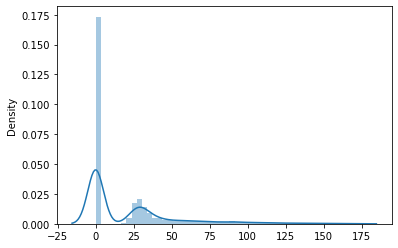

In [89]:
# subtract background
#bg = np.median(u, axis=0)
bg = np.min(u, axis=0)
us = u - bg
#im.View(im.zoom0(us,2), disp=['bg subtracted']*nt, cmap='nipy_spectral')

# temporal ~gaussian smoothing
for i in range(5):
    uss = us
    uss[1:-1] = (us[:-2]+us[1:-1]+us[2:])/3
    us = uss
# map of pixels with relative max >= activity_threshold
umax = np.max(us, axis=0)
#im.View(np.kron(umax, np.ones((2,2))), disp="max over time")
sns.distplot(umax)

In [90]:
activity_threshold =12
act0 = umax >= activity_threshold
im.View(im.zoom0(1*act0,2), disp='active pixels')

# see main activity period
umin = np.min(us, axis=0)
ubin = 1*((us-umin)>0.5*(umax-umin))
#im.View(ubin)

# consider temporal profile of active pixels only

act0xy = act0.reshape(nx*ny)
usxy = us.reshape((nt,nx*ny))
trajs = usxy[:,act0xy]
print(trajs.shape)

(1200, 3445)


# Check cluster stability

Optimal number of clusters based on stability: 3


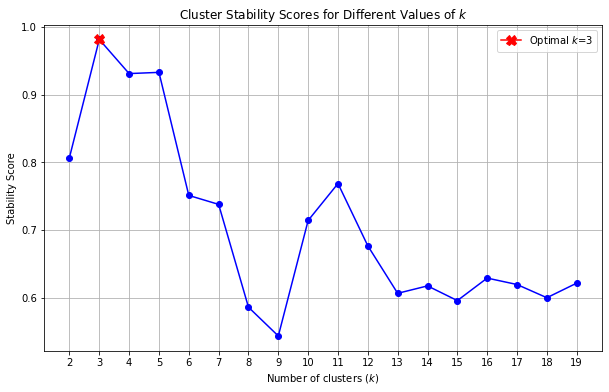

In [91]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

def cluster_stability(X, n_clusters_range, n_iter=20, random_state=None):
    rng = check_random_state(random_state)
    results = []

    for n_clusters in n_clusters_range:
        labels_list = []
        scores = []
        
        for i in range(n_iter):
            sample_indices = rng.randint(0, X.shape[0], X.shape[0])
            est = KMeans(n_clusters=n_clusters, random_state=rng.randint(1e8))
            est.fit(X[sample_indices])
            labels = np.full(X.shape[0], -1, dtype=int)
            labels[sample_indices] = est.labels_
            labels_list.append(labels)
        
        for i in range(len(labels_list)):
            for j in range(i + 1, len(labels_list)):
                valid_indices = (labels_list[i] != -1) & (labels_list[j] != -1)
                if np.any(valid_indices):
                    score = adjusted_rand_score(labels_list[i][valid_indices], labels_list[j][valid_indices])
                    scores.append(score)

        median_score = np.median(scores) if scores else 0
        results.append({'K value': n_clusters, 'Median Stability Score': median_score})

    return pd.DataFrame(results)


n_clusters_range = range(2, 20)
df_results = cluster_stability(trajs, n_clusters_range, n_iter=20, random_state=42)
Fish_ID = substring
df_results['Fish_ID'] = Fish_ID

# Save to CSV
df_results.to_csv(output_path + r'\median_stability_results.csv', index=False)

# Identify the number of clusters with the highest stability score
optimal_n_clusters = df_results.loc[df_results['Median Stability Score'].idxmax(), 'K value']
print(f"Optimal number of clusters based on stability: {optimal_n_clusters}")

# Plotting the stability scores
plt.figure(figsize=(10, 6))
plt.plot(df_results['K value'], df_results['Median Stability Score'], marker='o', linestyle='-', color='b')
plt.title('Cluster Stability Scores for Different Values of $k$')
plt.xlabel('Number of clusters ($k$)')
plt.ylabel('Stability Score')
plt.xticks(df_results['K value'])
plt.grid(True)

optimal_score = df_results.loc[df_results['Median Stability Score'].idxmax(), 'Median Stability Score']
plt.plot(optimal_n_clusters, optimal_score, marker='X', markersize=10, color='r', label=f'Optimal $k$={optimal_n_clusters}')
plt.legend()

plt.savefig(output_path + r'\kstability.pdf')
plt.show()


# Combining all fish

In [92]:
# Base directory path
base_dir = r'C:\Maha\DATA\dbh_activation_gfap_imaging_vnr\071223\analysis\3s\cluster_stability\full_length'

# List of directories (F2 to F14)
dirs = [f'F{i}' for i in range(2, 15)]

# Initialize an empty list to hold DataFrames
dfs = []

# Loop through directories and read CSV files
for dir in dirs:
    file_path = os.path.join(base_dir, dir, 'median_stability_results.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)


# Save the combined DataFrame and summary DataFrame to CSV
combined_csv_path = os.path.join(base_dir, 'combined_median_stability_results.csv')

combined_df.to_csv(combined_csv_path, index=False)

print(f"Combined CSV saved at: {combined_csv_path}")


Combined CSV saved at: C:\Maha\DATA\dbh_activation_gfap_imaging_vnr\071223\analysis\3s\cluster_stability\full_length\combined_median_stability_results.csv


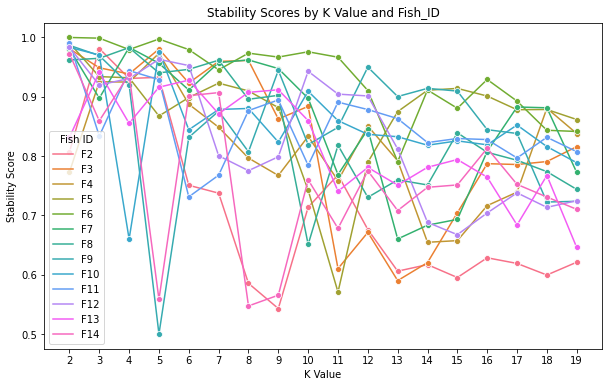

In [103]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='K value', y='Median Stability Score', hue='Fish_ID', marker='o')


plt.xticks(ticks=range(int(combined_df['K value'].min()), int(combined_df['K value'].max()) + 1))

plt.title('Stability Scores by K Value and Fish_ID')
plt.xlabel('K Value')
plt.ylabel('Stability Score')

plt.legend(title='Fish ID')
plt.savefig(base_dir + r'\ind_fish.pdf')
plt.savefig(base_dir + r'\ind_fish.svg')
plt.show()

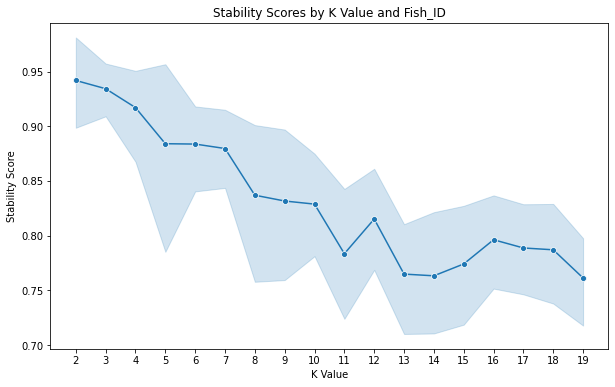

In [104]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='K value', y='Median Stability Score', marker='o')


plt.xticks(ticks=range(int(combined_df['K value'].min()), int(combined_df['K value'].max()) + 1))

plt.title('Stability Scores by K Value and Fish_ID')
plt.xlabel('K Value')
plt.ylabel('Stability Score')
plt.savefig(base_dir + r'\combined_scores.pdf')
plt.savefig(base_dir + r'\combined_scores.svg')

plt.show()

# compute noise floor and find the optimal number of K

In [95]:
import seaborn as sns

# Base directory path
base_dir = r'C:\Maha\DATA\dbh_activation_gfap_imaging_vnr\071223\analysis\3s\cluster_stability\full_length'

# List of directories (F2 to F14)
dirs = [f'F{i}' for i in range(2, 15)]

# Initialize an empty list to hold DataFrames
dfs = []

# Loop through directories and read CSV files
for dir in dirs:
    file_path = os.path.join(base_dir, dir, 'median_stability_results.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Source'] = dir  # Add a column to identify the source file
        dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)



Stability Scores: {2: 0.9418263853281252, 3: 0.9342837382599912, 4: 0.9170176736584739, 5: 0.8840107160571125, 6: 0.8836872895761954, 7: 0.8796290377942151, 8: 0.8369470128823016, 9: 0.8316485141160274, 10: 0.8288069967174756, 11: 0.7835040981844319, 12: 0.8151967872699509, 13: 0.7648439238857623, 14: 0.7632852823460343, 15: 0.7741207921655386, 16: 0.7962497176025365, 17: 0.7887276273189479, 18: 0.7870501137731645, 19: 0.7612977652239219}
Noise Floor: 0.8826727266307003
Max K above noise floor: 6


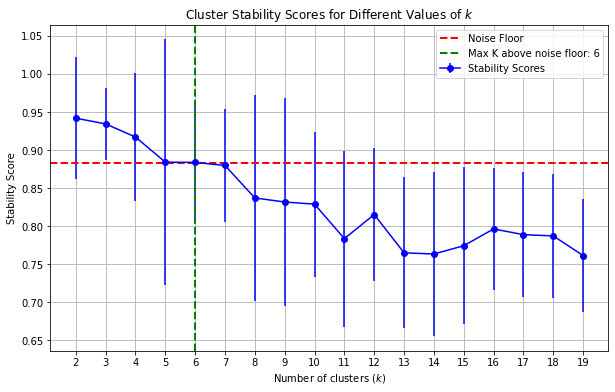

In [108]:
# Calculate mean and standard deviation of stability scores for each K value
grouped = combined_df.groupby('K value')['Median Stability Score']
mean_scores = grouped.mean()
std_scores = grouped.std()

#percentile
stability_scores = combined_df.groupby('K value')['Median Stability Score'].mean().to_dict()

# Estimate the noise floor using 75th percentile
upper_percentile = 0.75
noise_floor = np.percentile(list(stability_scores.values()), upper_percentile * 100)

max_k_above_noise = max([k for k in stability_scores if stability_scores[k] > noise_floor], default=None)

print("Stability Scores:", stability_scores)
print("Noise Floor:", noise_floor)
print("Max K above noise floor:", max_k_above_noise)

# Plotting the stability scores with noise floor, max K, and error bars
plt.figure(figsize=(10, 6))
n_clusters_list = list(stability_scores.keys())
scores = list(stability_scores.values())
errors = std_scores.loc[n_clusters_list]

# Plot the actual stability scores with error bars
plt.errorbar(n_clusters_list, scores, yerr=errors, fmt='o', linestyle='-', color='b', label='Stability Scores')

# Plot the noise floor
plt.axhline(y=noise_floor, color='r', linestyle='--', label='Noise Floor', linewidth=2)
plt.title('Cluster Stability Scores for Different Values of $k$')
plt.xlabel('Number of clusters ($k$)')
plt.ylabel('Stability Score')
plt.xticks(n_clusters_list)
plt.grid(True)


if max_k_above_noise is not None:
    plt.axvline(x=max_k_above_noise, color='g', linestyle='--', label=f'Max K above noise floor: {max_k_above_noise}', linewidth=2)
    plt.legend()

plt.legend()
plt.savefig(base_dir + r'\noise_percentile.pdf')
plt.savefig(base_dir + r'\noise_percentile.svg')
plt.show()


Stability Scores: {2: 0.9418263853281252, 3: 0.9342837382599912, 4: 0.9170176736584739, 5: 0.8840107160571125, 6: 0.8836872895761954, 7: 0.8796290377942151, 8: 0.8369470128823016, 9: 0.8316485141160274, 10: 0.8288069967174756, 11: 0.7835040981844319, 12: 0.8151967872699509, 13: 0.7648439238857623, 14: 0.7632852823460343, 15: 0.7741207921655386, 16: 0.7962497176025365, 17: 0.7887276273189479, 18: 0.7870501137731645, 19: 0.7612977652239219}
Noise Floor: 0.8317851928977893
Max K above noise floor: 8


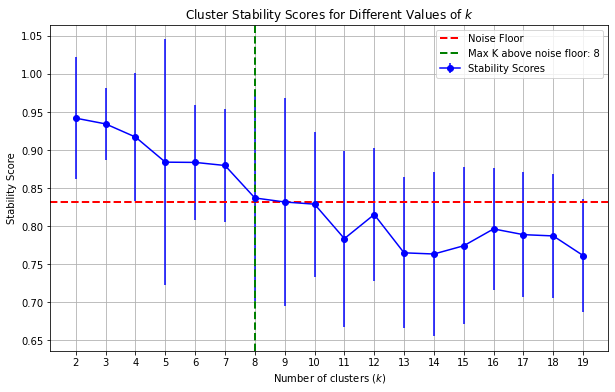

In [109]:
# Calculate mean and standard deviation of stability scores for each K value
grouped = combined_df.groupby('K value')['Median Stability Score']
mean_scores = grouped.mean()
std_scores = grouped.std()

#mean+-std
stability_scores = combined_df.groupby('K value')['Median Stability Score'].mean().to_dict()

# Estimate the noise floor using mean plus a certain number of standard deviations
mean_score = np.mean(list(stability_scores.values()))
std_dev_score = np.std(list(stability_scores.values()))
#noise_floor = mean_score + 1.5 * std_dev_score 
noise_floor = mean_score

max_k_above_noise = max([k for k in stability_scores if stability_scores[k] > noise_floor], default=None)

print("Stability Scores:", stability_scores)
print("Noise Floor:", noise_floor)
print("Max K above noise floor:", max_k_above_noise)

# Plotting the stability scores with noise floor, max K, and error bars
plt.figure(figsize=(10, 6))
n_clusters_list = list(stability_scores.keys())
scores = list(stability_scores.values())
errors = std_scores.loc[n_clusters_list]

# Plot the actual stability scores with error bars
plt.errorbar(n_clusters_list, scores, yerr=errors, fmt='o', linestyle='-', color='b', label='Stability Scores')
# Plot the noise floor
plt.axhline(y=noise_floor, color='r', linestyle='--', label='Noise Floor', linewidth=2)
plt.title('Cluster Stability Scores for Different Values of $k$')
plt.xlabel('Number of clusters ($k$)')
plt.ylabel('Stability Score')
plt.xticks(n_clusters_list)
plt.grid(True)


if max_k_above_noise is not None:
    plt.axvline(x=max_k_above_noise, color='g', linestyle='--', label=f'Max K above noise floor: {max_k_above_noise}', linewidth=2)
    plt.legend()

plt.legend()
plt.savefig(base_dir + r'\noise_mean.pdf')
plt.savefig(base_dir + r'\noise_mean.svg')
plt.show()


# Random code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import mode
from matplotlib.colors import ListedColormap

def run_kmeans_multiple(X, k, n_init=100, max_iter=100):
    n_samples, _ = X.shape
    all_labels = np.zeros((n_samples, n_init))

    for i in range(n_init):
        kmeans = KMeans(n_clusters=k, n_init=1, max_iter=max_iter, random_state=i)
        all_labels[:, i] = kmeans.fit_predict(X)

    # Consensus through mode
    final_labels = mode(all_labels, axis=1)[0].flatten()
    final_centers = np.array([X[final_labels == j].mean(axis=0) for j in range(k)])
    return final_centers, final_labels

# Assuming trajs is your input data for trajectories
n_time_points = trajs.shape[0]  # Number of time points
k = 5  # Number of clusters

# Run the stabilized k-means
C, I = run_kmeans_multiple(trajs.T, k, n_init=50, max_iter=1000)

# Check if we have k unique clusters
unique_clusters = np.unique(I)
print(f'Unique clusters found: {len(unique_clusters)}')

# If not, reduce k and re-run
if len(unique_clusters) < k:
    print(f"Reducing k to {len(unique_clusters)} and re-running K-means")
    k = len(unique_clusters)
    C, I = run_kmeans_multiple(trajs.T, k, n_init=50, max_iter=1000)

# Prepare the colormap
colors = [
    (1.0, 0.0, 0.0),  # Red
    (0.8, 0.2, 0.2),
    (0.6, 0.4, 0.4),
    (0.4, 0.6, 0.6),
    (0.2, 0.8, 0.8),  # Light Blue
]

# Plot the spatial map and fluorescence traces
fig, axes = plt.subplots(k, 2, figsize=(15, 5 * k))

for i in range(k):
    # Spatial map for the current cluster
    Ixy = np.full(nx * ny, np.nan)
    Ixy[act0xy] = (I == i)
    Ixy = Ixy.reshape((ny, nx))
    axes[i, 0].imshow(Ixy, cmap=ListedColormap([colors[i]]), vmin=0, vmax=1)
    axes[i, 0].set_title(f'Spatial Map - Class {i + 1}')

    # Temporal fluorescence trace
    axes[i, 1].plot(C[i], color=colors[i], label=f'Class {i + 1}')
    axes[i, 1].legend()
    axes[i, 1].set_xlabel('Time (s)')
    axes[i, 1].set_ylabel('Fluorescence Intensity')
    axes[i, 1].set_title(f'Fluorescence Trace - Class {i + 1}')

plt.tight_layout()
plt.savefig(output_path + r'\1_cluster_full_fish.pdf')

plt.show()